# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [1]:
from   glob   import glob
from   typing import Tuple, Callable, Dict
from   PIL    import Image
from   torch.utils.data       import DataLoader, Dataset
from   torchvision.transforms import Compose, ToTensor, Resize, Normalize
from   torch.nn               import Module

import torch.nn.functional as F
import matplotlib.pyplot   as plt
import numpy               as np 
import torch.nn            as nn
import torch.optim         as optim

import torch
import tests
import os

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [
                Resize(size),                 # Resize to the given size
                ToTensor(),                   # Convert image to tensor
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]  # Scale pixels to [-1, 1]  
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        
        # TODO: implement the init method
        self.directory   = directory
        self.transforms  = transforms
        self.extension   = extension
        self.image_files = [f for f in os.listdir(directory) if f.endswith(extension)]
        self.image_files.sort()  

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = os.path.join(self.directory, self.image_files[index])
        image = Image.open(img_path).convert("RGB")  # Ensure images are RGB
        
        # Apply transformations (if provided)
        if self.transforms:
            image = self.transforms(image)
            
        return image   

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

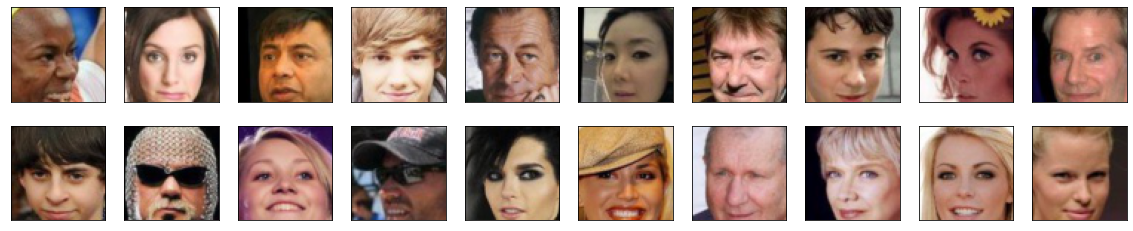

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
# from torch.nn import Module
# import torch.nn as nn

In [8]:
# Added by me
class ConvBlock(nn.Module):
    """
    A convolutional block made of Conv -> BatchNorm (optional) -> Activation.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 4, batch_norm: bool = True):
        super(ConvBlock, self).__init__()

        self.conv       = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.batch_norm(x)
        return self.activation(x)

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        self.model = nn.Sequential(
                                    ConvBlock(3  , 64, batch_norm=False),  # No BatchNorm in first layer
                                    ConvBlock(64 , 128),
                                    ConvBlock(128, 256),
                                    ConvBlock(256, 512),
                                    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Output score             
                                   )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        
        return self.model(x).view(-1, 1, 1, 1)

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
# Added by me
class DeconvBlock(nn.Module):
    """
    A "deconvolutional" block: ConvTranspose -> BatchNorm -> Activation.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 4, stride: int = 2, padding: int = 1):
        super(DeconvBlock, self).__init__()
        
        self.deconv     = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.activation(self.batch_norm(self.deconv(x)))

In [12]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        
        # TODO: instantiate the different layers
        self.model = nn.Sequential(
                    DeconvBlock(latent_dim, 512, kernel_size=4, stride=1, padding=0), # (latent_dim, 1, 1) → (512, 4, 4)

                    DeconvBlock(512, 256),  # (512, 4, 4) → (256, 8, 8)
                    DeconvBlock(256, 128),  # (256, 8, 8) → (128, 16, 16)
                    DeconvBlock(128, 64 ),  # (128, 16, 16) → (64, 32, 32)

                    # (Final RGB Image)
                    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), #(64, 32, 32) → (3, 64, 64)
                    nn.Tanh()  # Output scaled to [-1, 1]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        
        return self.model(x)

In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator  = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:

def create_optimizers(generator: Module, discriminator: Module):
    
    """Returns optimizers for generator and discriminator with adjusted learning rates."""
    
    # TODO: implement the generator and discriminator optimizers
    g_lr    = 0.0003  # Generator Learning Rate
    d_lr    = 0.0001  # Lower Discriminator LR to prevent overpowering
    beta1   = 0.5     # First moment decay (commonly 0.5 for GANs)
    beta2   = 0.999   # Second moment decay (default for Adam)
    
    g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(beta1, beta2))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(beta1, beta2))
    
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def real_loss(D_out, smooth):
    
    """Computes the real loss with optional label smoothing."""
    
    # TODO: implement the generator loss
    labels = torch.ones_like(D_out) * 0.9 if smooth else torch.ones_like(D_out)
    labels = labels.to(D_out.device)   # Ensure it's on the same device
    
    criterion = nn.BCEWithLogitsLoss()
    return criterion(D_out, labels)

def generator_loss(fake_logits):
    """Generator loss using smoothed real loss."""
    return real_loss(fake_logits, smooth=True)  # Pass fake_logits instead of undefined D_fake


### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits, smooth=True):
    
    """Discriminator loss using BCE with optional label smoothing."""
    
    # TODO: implement the discriminator loss
    criterion = nn.BCEWithLogitsLoss()

    # Use real_loss function for real images
    real_loss_value = real_loss(real_logits, smooth=smooth)  # Apply label smoothing if enabled

    # Compute loss for fake images (no smoothing, target = 0)
    fake_loss_value = criterion(fake_logits, torch.zeros_like(fake_logits))

    return real_loss_value + fake_loss_value  # Sum both losses

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    
    g_optimizer.zero_grad()  # Zero gradients
    
    # Sample latent vector `z` from uniform distribution in [-1,1] using NumPy
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    
    # Convert NumPy array to PyTorch tensor and move to GPU
    z = torch.from_numpy(z).float().to(device)

    # Generate fake images
    fake_images = generator(z)
    
    # Get discriminator predictions on fake images
    fake_logits = discriminator(fake_images)
    
    # Compute generator loss (calls real_loss internally)
    g_loss = generator_loss(fake_logits)
    
    # Backpropagation
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}




def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor, smooth: bool = True, use_gp: bool = False) -> Dict:
    """ One training step of the discriminator. """

    d_optimizer.zero_grad()  # Zero gradients

    # Move real images to device
    real_images = real_images.to(device)

    # Get discriminator predictions for real images
    real_logits = discriminator(real_images)

    # Generate fake images using NumPy
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))

    # Convert NumPy array to PyTorch tensor and move to GPU
    z = torch.from_numpy(z).float().to(device)

    # Generate fake images
    fake_images = generator(z).detach()  # Detach to prevent gradients from flowing into G

    # Get discriminator predictions for fake images
    fake_logits = discriminator(fake_images)

    # Compute discriminator loss with label smoothing
    d_loss = discriminator_loss(real_logits, fake_logits, smooth=smooth)

    # Apply Gradient Penalty if needed (for WGAN-GP)
    gp = 0
    if use_gp:
        gp = gradient_penalty(discriminator, real_images, fake_images)
        d_loss += 10 * gp  # λ = 10 (default in WGAN-GP)

    # Backpropagation
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss}


### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [20]:
from datetime import datetime

In [ ]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128
device     = 'cuda'  # update to cpu if you do not have access to a gpu
n_epochs   = 1       # number of epochs to train your model
batch_size = 64      # number of images in each batch

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2025-03-19 00:39:30 | Epoch [1/10] | Batch 0/509 | d_loss: 0.6372 | g_loss: 2.5346
2025-03-19 00:39:49 | Epoch [1/10] | Batch 100/509 | d_loss: 0.3704 | g_loss: 4.4891
2025-03-19 00:40:08 | Epoch [1/10] | Batch 200/509 | d_loss: 0.4800 | g_loss: 3.0757
2025-03-19 00:40:26 | Epoch [1/10] | Batch 300/509 | d_loss: 0.4494 | g_loss: 3.9978
2025-03-19 00:40:44 | Epoch [1/10] | Batch 400/509 | d_loss: 0.4992 | g_loss: 3.7754
2025-03-19 00:41:02 | Epoch [1/10] | Batch 500/509 | d_loss: 0.5602 | g_loss: 2.8184


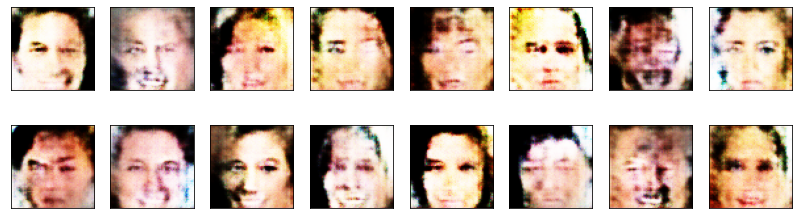

2025-03-19 00:41:09 | Epoch [2/10] | Batch 0/509 | d_loss: 0.4983 | g_loss: 3.5267
2025-03-19 00:41:27 | Epoch [2/10] | Batch 100/509 | d_loss: 0.6765 | g_loss: 3.0477
2025-03-19 00:41:45 | Epoch [2/10] | Batch 200/509 | d_loss: 0.6118 | g_loss: 2.1701
2025-03-19 00:42:03 | Epoch [2/10] | Batch 300/509 | d_loss: 0.4565 | g_loss: 3.1185
2025-03-19 00:42:21 | Epoch [2/10] | Batch 400/509 | d_loss: 0.6068 | g_loss: 2.8227
2025-03-19 00:42:39 | Epoch [2/10] | Batch 500/509 | d_loss: 0.5287 | g_loss: 2.8075


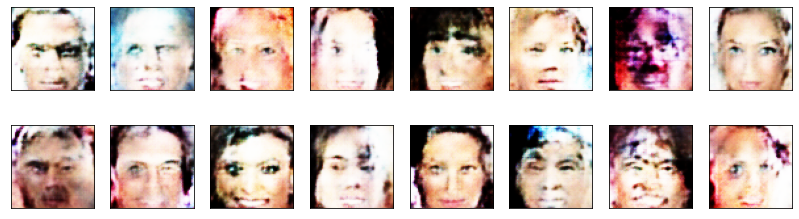

2025-03-19 00:42:44 | Epoch [3/10] | Batch 0/509 | d_loss: 0.5277 | g_loss: 2.5369
2025-03-19 00:43:02 | Epoch [3/10] | Batch 100/509 | d_loss: 0.4473 | g_loss: 3.7350
2025-03-19 00:43:20 | Epoch [3/10] | Batch 200/509 | d_loss: 0.4112 | g_loss: 4.0184
2025-03-19 00:43:38 | Epoch [3/10] | Batch 300/509 | d_loss: 0.6132 | g_loss: 2.3072
2025-03-19 00:43:56 | Epoch [3/10] | Batch 400/509 | d_loss: 0.4932 | g_loss: 2.7823
2025-03-19 00:44:14 | Epoch [3/10] | Batch 500/509 | d_loss: 3.8991 | g_loss: 2.6567


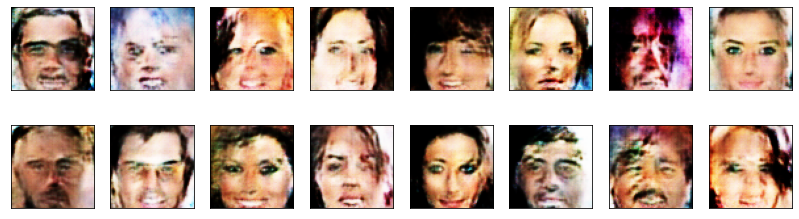

2025-03-19 00:44:19 | Epoch [4/10] | Batch 0/509 | d_loss: 0.6219 | g_loss: 2.3530
2025-03-19 00:44:37 | Epoch [4/10] | Batch 100/509 | d_loss: 0.4484 | g_loss: 3.5947
2025-03-19 00:44:55 | Epoch [4/10] | Batch 200/509 | d_loss: 0.3693 | g_loss: 4.7551
2025-03-19 00:45:13 | Epoch [4/10] | Batch 300/509 | d_loss: 1.0108 | g_loss: 3.7767
2025-03-19 00:45:31 | Epoch [4/10] | Batch 400/509 | d_loss: 0.3594 | g_loss: 3.3279
2025-03-19 00:45:49 | Epoch [4/10] | Batch 500/509 | d_loss: 0.7485 | g_loss: 2.3491


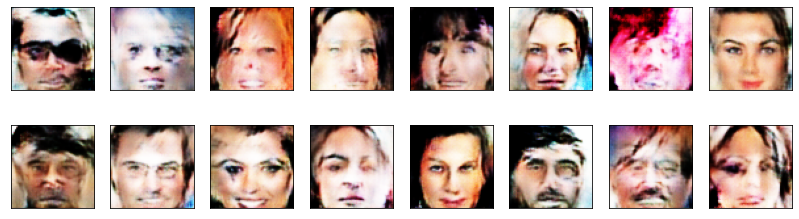

2025-03-19 00:45:54 | Epoch [5/10] | Batch 0/509 | d_loss: 0.3521 | g_loss: 4.4794
2025-03-19 00:46:12 | Epoch [5/10] | Batch 100/509 | d_loss: 0.3838 | g_loss: 4.3570
2025-03-19 00:46:30 | Epoch [5/10] | Batch 200/509 | d_loss: 0.7275 | g_loss: 3.3447
2025-03-19 00:46:48 | Epoch [5/10] | Batch 300/509 | d_loss: 0.4093 | g_loss: 3.8498
2025-03-19 00:47:06 | Epoch [5/10] | Batch 400/509 | d_loss: 0.3795 | g_loss: 3.9018
2025-03-19 00:47:24 | Epoch [5/10] | Batch 500/509 | d_loss: 0.8358 | g_loss: 3.8239


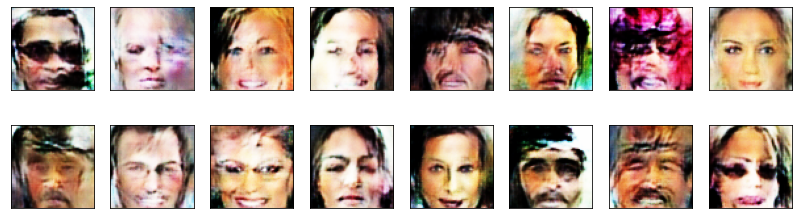

2025-03-19 00:47:30 | Epoch [6/10] | Batch 0/509 | d_loss: 0.4147 | g_loss: 3.4273
2025-03-19 00:47:48 | Epoch [6/10] | Batch 100/509 | d_loss: 0.3930 | g_loss: 4.0206
2025-03-19 00:48:06 | Epoch [6/10] | Batch 200/509 | d_loss: 0.4397 | g_loss: 3.2429
2025-03-19 00:48:24 | Epoch [6/10] | Batch 300/509 | d_loss: 1.0272 | g_loss: 1.7982
2025-03-19 00:48:42 | Epoch [6/10] | Batch 400/509 | d_loss: 0.3924 | g_loss: 3.8957
2025-03-19 00:49:00 | Epoch [6/10] | Batch 500/509 | d_loss: 0.4648 | g_loss: 3.2467


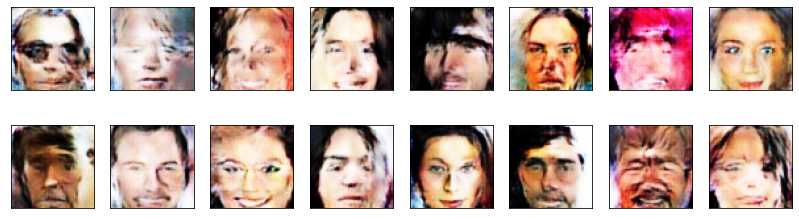

2025-03-19 00:49:06 | Epoch [7/10] | Batch 0/509 | d_loss: 0.4282 | g_loss: 4.1918
2025-03-19 00:49:24 | Epoch [7/10] | Batch 100/509 | d_loss: 0.4433 | g_loss: 2.6875
2025-03-19 00:49:42 | Epoch [7/10] | Batch 200/509 | d_loss: 0.5358 | g_loss: 3.0524
2025-03-19 00:50:00 | Epoch [7/10] | Batch 300/509 | d_loss: 0.3580 | g_loss: 4.1943
2025-03-19 00:50:18 | Epoch [7/10] | Batch 400/509 | d_loss: 0.4139 | g_loss: 3.0952
2025-03-19 00:50:36 | Epoch [7/10] | Batch 500/509 | d_loss: 0.3847 | g_loss: 3.6802


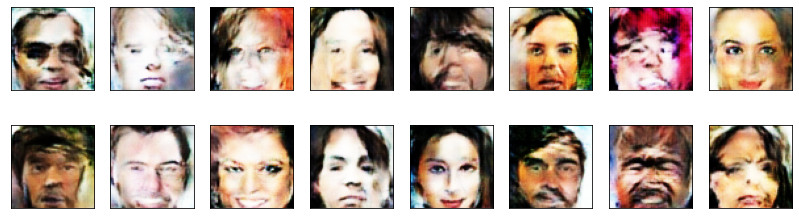

2025-03-19 00:50:41 | Epoch [8/10] | Batch 0/509 | d_loss: 0.3486 | g_loss: 4.8858
2025-03-19 00:50:59 | Epoch [8/10] | Batch 100/509 | d_loss: 0.3530 | g_loss: 4.2505
2025-03-19 00:51:17 | Epoch [8/10] | Batch 200/509 | d_loss: 0.3617 | g_loss: 4.5424
2025-03-19 00:51:35 | Epoch [8/10] | Batch 300/509 | d_loss: 0.3550 | g_loss: 4.7490
2025-03-19 00:51:53 | Epoch [8/10] | Batch 400/509 | d_loss: 0.4031 | g_loss: 4.1017
2025-03-19 00:52:11 | Epoch [8/10] | Batch 500/509 | d_loss: 0.3639 | g_loss: 4.5204


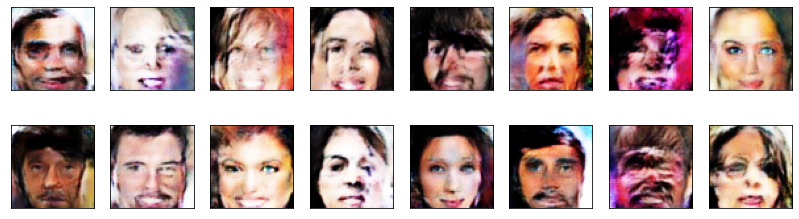

2025-03-19 00:52:17 | Epoch [9/10] | Batch 0/509 | d_loss: 0.3710 | g_loss: 5.0975
2025-03-19 00:52:35 | Epoch [9/10] | Batch 100/509 | d_loss: 0.3742 | g_loss: 4.7905
2025-03-19 00:52:53 | Epoch [9/10] | Batch 200/509 | d_loss: 0.3550 | g_loss: 3.4841
2025-03-19 00:53:11 | Epoch [9/10] | Batch 300/509 | d_loss: 0.3609 | g_loss: 3.6840
2025-03-19 00:53:28 | Epoch [9/10] | Batch 400/509 | d_loss: 0.4749 | g_loss: 3.1347
2025-03-19 00:53:46 | Epoch [9/10] | Batch 500/509 | d_loss: 0.3949 | g_loss: 3.4632


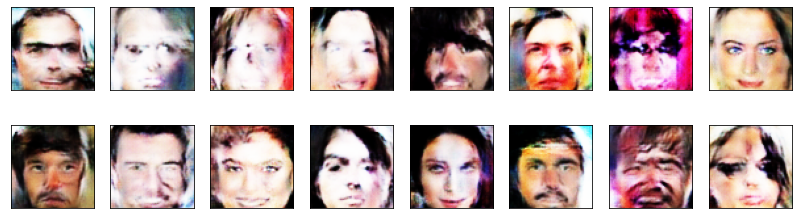

2025-03-19 00:53:52 | Epoch [10/10] | Batch 0/509 | d_loss: 0.4808 | g_loss: 2.9979
2025-03-19 00:54:10 | Epoch [10/10] | Batch 100/509 | d_loss: 0.4776 | g_loss: 4.9058
2025-03-19 00:54:28 | Epoch [10/10] | Batch 200/509 | d_loss: 0.3446 | g_loss: 5.0626
2025-03-19 00:54:47 | Epoch [10/10] | Batch 300/509 | d_loss: 0.5157 | g_loss: 4.3468
2025-03-19 00:55:05 | Epoch [10/10] | Batch 400/509 | d_loss: 0.3808 | g_loss: 4.7654
2025-03-19 00:55:22 | Epoch [10/10] | Batch 500/509 | d_loss: 2.5760 | g_loss: 2.3885


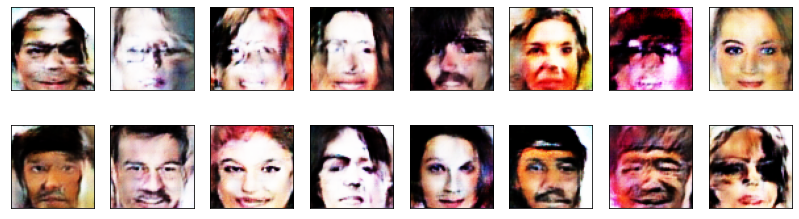

In [24]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

n_epochs    = 10
d_steps     = 2  # Train Discriminator more than Generator
print_every = 100
losses      = []
use_gp      = False  # Define outside loop to avoid redefining each iteration

for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        ####################################
        # Training Strategy Implementation
        ####################################

        for _ in range(d_steps):
            d_loss = discriminator_step(batch_size, latent_dim, real_images, smooth=True, use_gp=use_gp)  # Pass smoothing and GP setting

        # Train the generator
        g_loss = generator_step(batch_size, latent_dim)

        ####################################

        if batch_i % print_every == 0:
            # Ensure loss values are extracted properly
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()

            # Append losses
            losses.append((d, g))

            # Print loss update
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # Display generated images after each epoch
    generator.eval()
    with torch.no_grad():  # Prevents gradient tracking during inference
        generated_images = generator(fixed_latent_vector)

    display(generated_images)  # Function to visualize images
    generator.train()


### Training losses

Plot the training losses for the generator and discriminator.

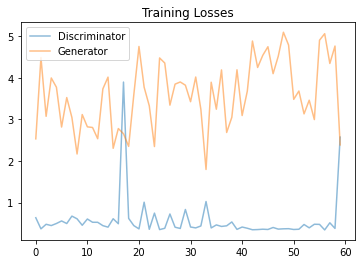

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 

## Observations on Generated Samples & Possible Improvements

### 1. Dataset Bias  
- The dataset consists mostly of celebrity faces, which introduces bias toward certain ethnicities.  
- **Improvement:** Use a more diverse dataset or apply data augmentation techniques to improve generalization.

### 2. Model Size & Complexity  
- The current model is able to generate faces, but increasing the **depth (more layers) or feature maps** could help capture finer details.  
- **Improvement:** Experiment with deeper convolutional layers in both the generator and discriminator while monitoring training stability.

### 3. Optimization Strategy  
- The model is training well, but **training for more epochs (e.g., 20–50)** could improve image quality.  
- The **learning rate (LR) and β values** in Adam also affect training stability.  
- **Improvement:** Fine-tune **LR schedules**, adjust **β1**, or try different optimizers like **RMSprop** for stability.

### 4. Loss Functions  
- The use of **Binary Cross-Entropy with Logits (BCEWithLogitsLoss)** is standard, but other loss functions like **Wasserstein loss** could help improve gradient flow.  
- **Improvement:** Try **WGAN-GP** (gradient penalty) or **Hinge loss** for improved sample quality.

### Conclusion  
The model is now **generating recognizable faces**, which is a great step! The next improvements should focus on **training duration, model architecture, and dataset diversity** to produce even more realistic outputs.



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.